In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def show_image(filepath):
    plt.figure(figsize=(20, 10))
    plt.imshow(mpimg.imread(filepath))
    plt.show()

In [3]:
def mse(y_pred, y):
    return ((y_pred - y)**2).mean()

In [4]:
FEATURES = ["category_gry i konsole", "category_komputery", "category_sprzęt rtv", "category_telefony i akcesoria", "city_Gdynia", "city_Konin", "city_Kutno", "city_Mielec", "city_Police", "city_Radom", "city_Szczecin", "city_Warszawa", "delivery_company_360", "delivery_company_516", "delivery_company_620", "price", "purchase_day", "purchase_day_cos", "purchase_day_sin", "purchase_dayofweek", "purchase_dayofweek_cos", "purchase_dayofweek_sin", "purchase_hour", "purchase_hour_cos", "purchase_hour_sin", "purchase_minute", "purchase_minute_cos", "purchase_minute_sin", "purchase_month", "purchase_month_cos", "purchase_month_sin", "purchase_second", "purchase_second_cos", "purchase_second_sin", "purchase_year"]
TARGET = "hours"

In [5]:
train = pd.read_csv("../data_preprocessed/train.csv")
dev = pd.read_csv("../data_preprocessed/dev.csv")
test = pd.read_csv("../data_preprocessed/test.csv")

In [6]:
model_simple = {}
for _, row in pd.read_csv("../models/statistic_for_simple_model.csv").iterrows():
    model_simple[row["city"]] = row["mean"]

In [7]:
model_xgb = xgb.XGBRegressor()
model_xgb.load_model("../models/xgboost.json")

In [8]:
model_forest: RandomForestRegressor = joblib.load("../models/random_forest.joblib")

Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


# Ewaluacja

## Model prosty

In [9]:
print("train", mse(train["city"].apply(lambda x: model_simple[x]), train[TARGET]))
print("dev", mse(dev["city"].apply(lambda x: model_simple[x]), dev[TARGET]))
print("test", mse(test["city"].apply(lambda x: model_simple[x]), test[TARGET]))

train 174.85142201007793
dev 167.55261892010134
test 174.3634109604925


## Model złożony 1 (wzmocnienie gradientowe)

In [10]:
print("train", mse(model_xgb.predict(train[FEATURES]), train[TARGET]))
print("dev", mse(model_xgb.predict(dev[FEATURES]), dev[TARGET]))
print("test", mse(model_xgb.predict(test[FEATURES]), test[TARGET]))

train 103.23799319698234
dev 124.16700687705581
test 127.37629193407703


## Model złożony 2 (las losowy)

In [11]:
print("train", mse(model_forest.predict(train[FEATURES]), train[TARGET]))
print("dev", mse(model_forest.predict(dev[FEATURES]), dev[TARGET]))
print("test", mse(model_forest.predict(test[FEATURES]), test[TARGET]))

train 17.81580933131851
dev 123.03650324868407
test 127.99668029249824


W porównaniu do modelu prostego obydwa modele złożone mają o 27% niższy błąd średnio-kwadratowy na zbiorze testowym, zatem opłaca się wdrożyć co najmniej jeden z nich. Model prosty zwraca średni czas dostawy dla danego miasta. Pierwszy model złożony miał optymalizowane hiperparametry związane z generacją drzew i podziałem atrybutów. Drugi model złożony nie wymagał optymalizacji hiperparametrów. Las losowy wydaje się być stabilniejszym rozwiązaniem, biorąc pod uwagę lepszy wynik na zbiorze treningowym (zazwyczaj ciężko jest przeuczyć las losowy).

# Atrybuty

Atrybuty ciągłe zostały znormalizowane. Atrybuty dyskretne zostały zakodowane tzw. gorącą jedynką. Atrybuty dyskretne cykliczne zostały zakodowane za pomocą dwóch zmiennych ciągłych. Do najważniejszych atrybutów należą: miasto, dzień tygodnia, firma kurierska.

Przykładowy wpływ atrybutów na czas dostawy:

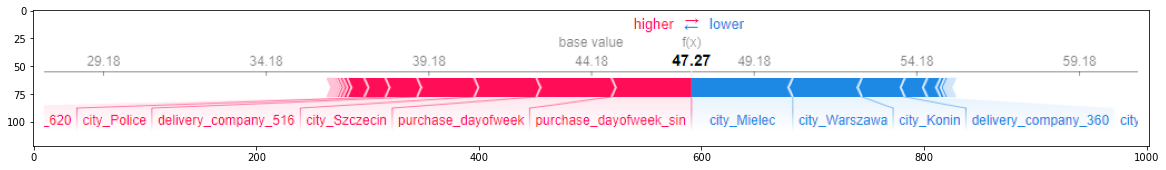

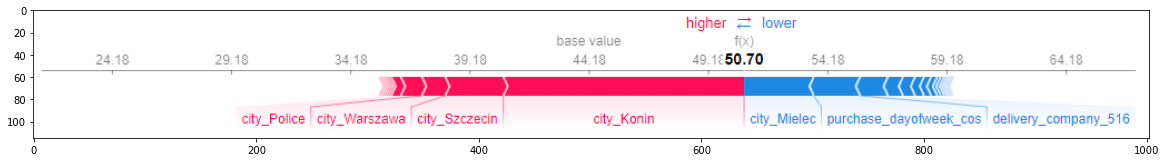

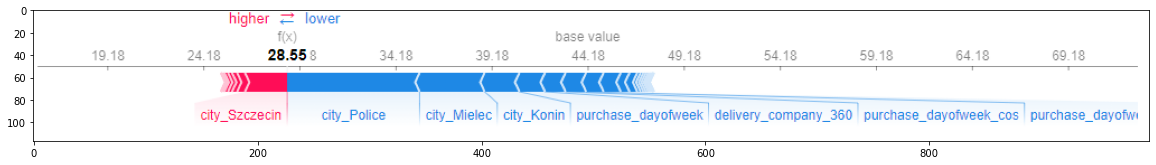

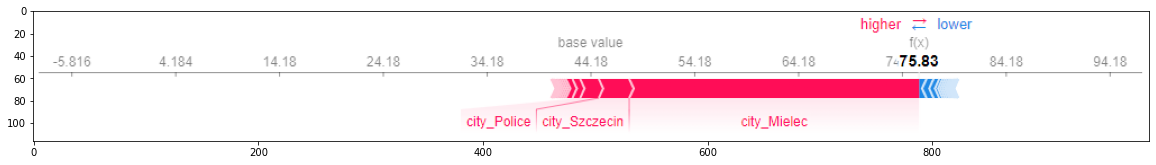

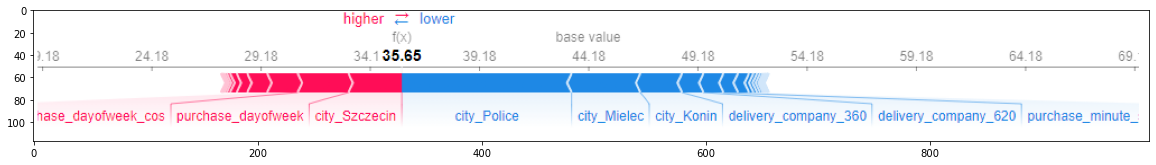

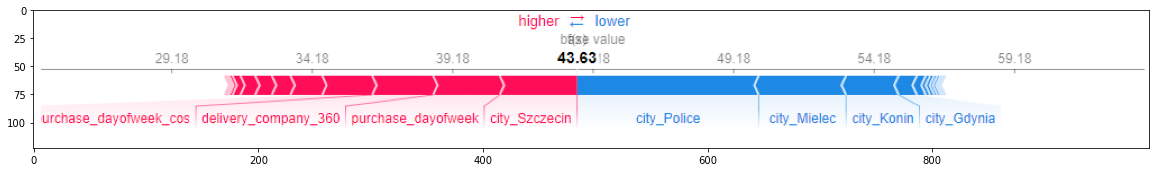

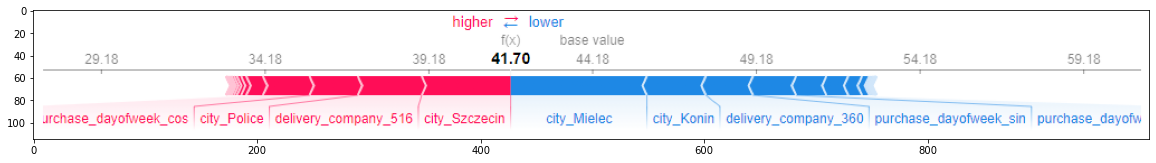

In [12]:
for i in range(1, 8):
    show_image("../img/shap{}.png".format(i))